# baselines

(6.0, 10.0)

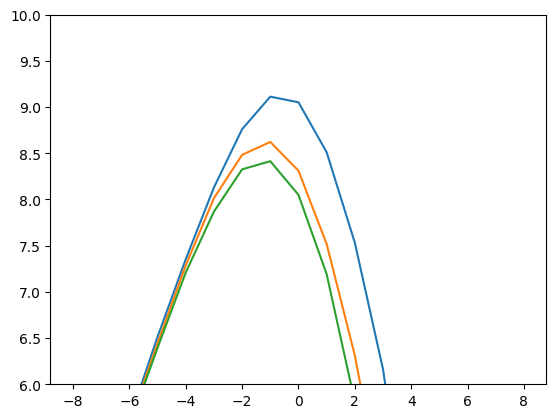

In [1]:
import numpy as np, matplotlib.pyplot as plt, pickle
from src.TorchDSP.dataloader import get_k, get_k_batch
res, code = pickle.load(open('_outputs/Qfactor/Nmodes2/CDC.pkl','rb'))
P = np.arange(-8, 9)
Rs = 40
s = 1

k = get_k_batch(1, Rs, code)
Q = res['BER from 10000th symb']['CDC']['Qsq'][k][:,s]
# Q = np.mean(Q, axis=1)
plt.plot(P, Q)

k = get_k_batch(3, Rs, code)
Q = res['BER from 10000th symb']['CDC']['Qsq'][k][:,s]
# Q = np.mean(Q, axis=1)
plt.plot(P, Q)

k = get_k_batch(5, Rs, code)
Q = res['BER from 10000th symb']['CDC']['Qsq'][k][:,s]
# Q = np.mean(Q, axis=1) 
plt.plot(P, Q)

plt.ylim(6, 10)

# data

In [2]:
import torch
from src.TorchDSP.dataloader import  get_signals, opticDataset
from src.TorchDSP.nneq import eqBiLSTM, eqMLP, eqCNNBiLSTM, eqID, eqAMPBC, eqAMPBCaddNN
from src.TorchDSP.pbc import models
import torch, numpy as np
import scipy.constants as const, scipy.special as special
from src.TorchSimulation.receiver import  BER

def MSE(predict, truth):
    return torch.mean(torch.abs(predict - truth)**2)  # predict, truth: [B, Nmodes]

def SNR(predict, truth):
    return 10 * torch.log10(torch.mean(torch.abs(truth)**2) / torch.mean(torch.abs(predict - truth)**2))

def Qsq(ber):
    return 20 * np.log10(np.sqrt(2) * np.maximum(special.erfcinv(2 * ber), 0.))

def test_model(dataloader, model, loss_fn, device):
    model = model.to(device)
    model.eval()
    mse = 0 
    ber = 0
    power = 0

    N = len(dataloader)
    predicts = []
    truths = []
    with torch.no_grad():
        for x, y, z in dataloader:
            x, y, z = x.to(device), y.to(device), z.to(device)
            y_pred = model(x)
            mse += loss_fn(y_pred, y).item()
            power += MSE(0, y).item()
            ber += BER(y, y_pred)['BER']
            predicts.append(y_pred.cpu().numpy())
            truths.append(y.cpu().numpy())
            
    return {'loss_fn': mse/N, 'BER': np.mean(ber/N), 'SNR': 10 * np.log10(power / mse), 'Qsq': Qsq(np.mean(ber/N)), 'BER_XY':ber/N, 'Qsq_XY': Qsq(ber/N)}, np.concatenate(predicts, axis=0), np.concatenate(truths, axis=0)


In [3]:
test_path = 'data/lab/test_2_0_4_1.pkl'
train_path = 'data/lab/train_1_0_4_1.pkl'
idx_train = (100000, 1100000)
idx_test = (1100000, 1200000)

In [4]:
# config.yaml
train_path = "data/Nmodes2/train_batch10_4e5_afterCDCDSP.pkl"
test_path = "data/Nmodes2/test_batch10_4e5_afterCDCDSP.pkl"
idx_train = [10000, -1]
idx_test = [10000, -1]
Nch = 3
Rs = 40
Pch = [2]

In [6]:
Memory = 41
trainset = opticDataset(Nch=Nch, Rs=Rs, M=Memory,Pch=Pch,  path=train_path, idx=idx_train, power_fix=False)
testset = opticDataset(Nch=Nch, Rs=Rs, M=Memory, Pch=Pch, path=test_path, idx=idx_test, power_fix=False)

# construct dataloader: optcDataset
from torch.utils.data import DataLoader
train_loader = DataLoader(trainset, batch_size=5000, shuffle=True)
test_loader = DataLoader(testset, batch_size=5000, shuffle=False)

# TorchSignal
signal, truth, z = get_signals(test_path, Nch=Nch, Rs=Rs, Pch=Pch,  device='cpu')
# for y,x,z in train_loader:
#     print(y.shape, x.shape, z.shape)
#     break

In [7]:
torch.min(torch.abs(truth.val.real))

tensor(0.3162)

In [8]:
# print number of parameters
# net = eqMLP(M=Memory)
net = eqCNNBiLSTM(M=201, channels=64, kernel_size=101, hidden_size=40, res_net=True)
print('Number of net parameters: ', sum(p.numel() for p in net.parameters() if p.requires_grad))

Number of net parameters:  92160


In [10]:
test_model(test_loader, eqID(M=Memory), loss_fn=MSE, device='cpu')

({'loss_fn': 0.050123419095244676,
  'BER': 0.020715848,
  'SNR': 13.001740677579273,
  'Qsq': 6.189127099024729,
  'BER_XY': array([0.02077705, 0.02065464], dtype=float32),
  'Qsq_XY': array([6.1839056, 6.1943583], dtype=float32)},
 array([[-0.25065905+0.14074564j,  0.1934876 -0.46558994j],
        [-0.82554877-0.99100757j,  0.79408777-0.94647086j],
        [ 0.25819013+0.27068037j, -0.05671802-0.00763169j],
        ...,
        [ 1.0279646 -0.40970212j,  0.68750924+0.3567427j ],
        [ 0.8773032 -0.57705694j,  1.1801907 +0.9083901j ],
        [ 0.96344215+0.85928243j, -0.89864886+0.26948044j]],
       dtype=complex64),
 array([[-0.31622776+0.31622776j,  0.31622776-0.31622776j],
        [-0.9486833 -0.9486833j ,  0.9486833 -0.9486833j ],
        [ 0.31622776+0.31622776j, -0.31622776+0.31622776j],
        ...,
        [ 0.9486833 -0.31622776j,  0.9486833 +0.31622776j],
        [ 0.9486833 -0.31622776j,  0.9486833 +0.9486833j ],
        [ 0.9486833 +0.9486833j , -0.9486833 +0.3162277

# MLP

In [11]:
import pickle, torch
dic = torch.load('_models/simulation_nn_Nch3_Rs40_Pch-1_discard_M41/MLP.ckpt100', map_location='cpu')
net = globals()[dic['model_name']](**dic['model info'])
net.load_state_dict(dic['model'])
metric, y, x = test_model(test_loader, net, loss_fn=MSE, device='cpu')
metric

{'loss_fn': 0.04973427868551678,
 'BER': 0.020707719,
 'SNR': 13.035589322579511,
 'Qsq': 6.189821282827901,
 'BER_XY': array([0.02071213, 0.02070331], dtype=float32),
 'Qsq_XY': array([6.189446, 6.190198], dtype=float32)}

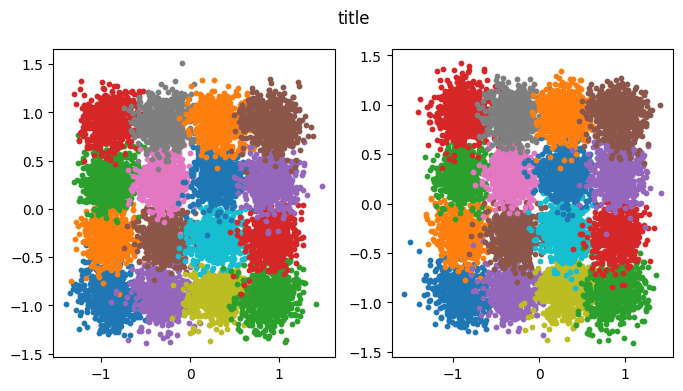

In [12]:
from src.JaxSimulation.utils import show_symb
show_symb(y[100000: 110000], x[100000: 110000])

# BiLSTM

In [13]:
import pickle, torch
dic = torch.load('_models/simulation_nn_Nch3_Rs40_Pch-1_discard_M41/BiLSTM.ckpt100', map_location='cpu')
net = globals()[dic['model_name']](**dic['model info'])
net.load_state_dict(dic['model'])
metric, y, x = test_model(test_loader, net, loss_fn=MSE, device='cpu')
metric

{'loss_fn': 0.042765336111187935,
 'BER': 0.01965417,
 'SNR': 13.691228661633676,
 'Qsq': 6.281325750128265,
 'BER_XY': array([0.01982864, 0.01947971], dtype=float32),
 'Qsq_XY': array([6.2659574, 6.296783 ], dtype=float32)}

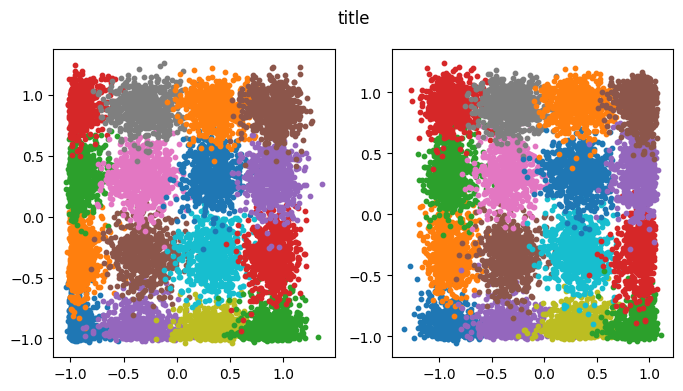

In [14]:
from src.JaxSimulation.utils import show_symb

show_symb(y[100000: 110000], x[100000: 110000])

# CNNBiLSTM

In [15]:
import pickle, torch
dic = torch.load('_models/simulation_nn_Nch3_Rs40_Pch-1_discard_M41/CNNBiLSTM.ckpt100', map_location='cpu')
net = globals()[dic['model_name']](**dic['model info'])
net.load_state_dict(dic['model'])
metric, y, x = test_model(test_loader, net, loss_fn=MSE, device='cpu')
metric

{'loss_fn': 0.04577295254502031,
 'BER': 0.01709913,
 'SNR': 13.396058287255562,
 'Qsq': 6.5173962331676,
 'BER_XY': array([0.0170557 , 0.01714256], dtype=float32),
 'Qsq_XY': array([6.5216045, 6.513195 ], dtype=float32)}

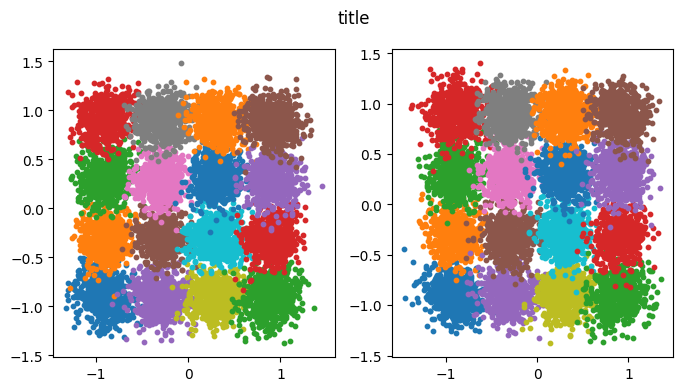

In [16]:
from src.JaxSimulation.utils import show_symb

show_symb(y[100000: 110000], x[100000: 110000])

# PBC

In [17]:
import pickle, torch
import src.TorchDSP.train_pbc as pbc
dic = torch.load('_models/simulation_nn_Nch3_Rs40_Pch-1/AMPBC_L200', map_location='cpu')
net = models[dic['model_name']](**dic['model info'])
net.load_state_dict(dic['model'])
y,x = pbc.test_model(dic,  signal, truth, z, device='cpu') 

Testing: 
Time cost: 7.366209030151367


In [18]:
metric = pbc.calculate_BER(y, x, n=10000)

Calculate BER discard 10000 symbols
Time for each BER calculation:  0.1084744930267334


In [19]:
metric['Qsq']

array([[7.1460958, 6.2669992],
       [7.0854764, 6.301474 ]], dtype=float32)

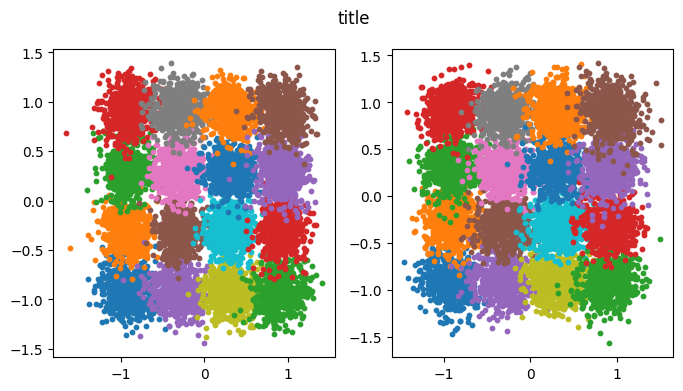

In [20]:

show_symb(y.numpy()[0, 10000:20000], x.numpy()[0, 10000:20000])

# PBC Pch = 2 

In [23]:
for y1,x1,z in test_loader:
    break

In [24]:
import pickle, torch
# dic = torch.load('_models/simulation_nneq/Test5_Pch2/eqAMPBCaddNN_rho4_splitlr_alter0.ckpt60', map_location='cpu')
dic = torch.load('_models/simulation_nneq/Test5_Pch2/eqAMPBC_rho4.ckpt60', map_location='cpu')
net = globals()[dic['model_name']](**dic['model info'])
net.load_state_dict(dic['model'])
metric, y, x = test_model(test_loader, net, loss_fn=MSE, device='cpu')
metric

{'loss_fn': 0.04070479039930635,
 'BER': 0.0121104205,
 'SNR': 13.905692330721639,
 'Qsq': 7.0575674280395475,
 'BER_XY': array([0.01204538, 0.01217546], dtype=float32),
 'Qsq_XY': array([7.0655446, 7.0496206], dtype=float32)}

In [25]:
y_pbc0 = net(y1).data

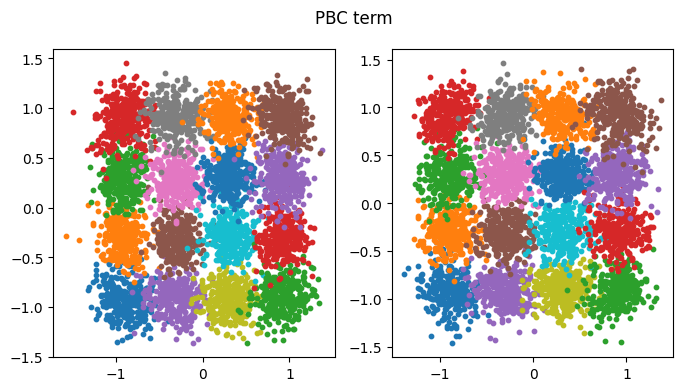

In [26]:
show_symb(y_pbc0.data, x1.numpy(), title='PBC term')

# AMPBC + NN

In [27]:
for y1,x1,z in test_loader:
    break

In [28]:
import pickle, torch
# dic = torch.load('_models/simulation_nneq/Test5_Pch2/eqAMPBCaddNN_rho4_splitlr_alter0.ckpt60', map_location='cpu')
dic = torch.load('_models/simulation_nneq/Test5_Pch2/eqAMPBCaddNN_rho4_splitlr_alter0_adaptloss.ckpt40', map_location='cpu')
net = globals()[dic['model_name']](**dic['model info'])
net.load_state_dict(dic['model'])
# metric, y, x = test_model(test_loader, net, loss_fn=MSE, device='cpu')
# metric

<All keys matched successfully>

In [29]:
y_pbc = net.pbc(y1).data
y_nn = net.nn(y1).data

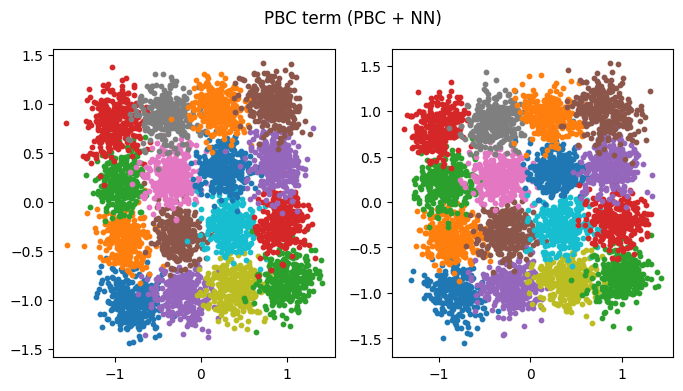

In [30]:
show_symb(y_pbc.numpy(), x1.numpy(), title='PBC term (PBC + NN)')

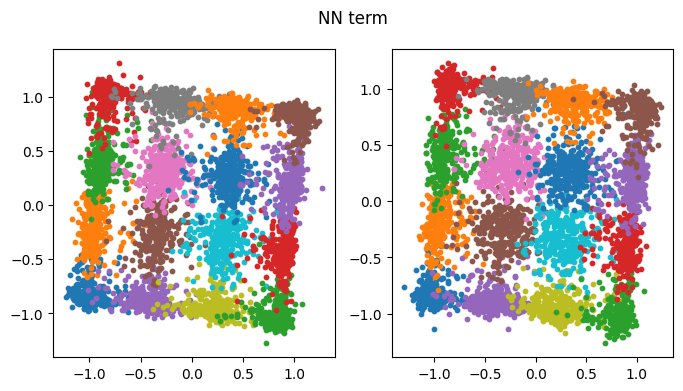

In [31]:
show_symb(y_nn.numpy(), x1.numpy(), title='NN term')

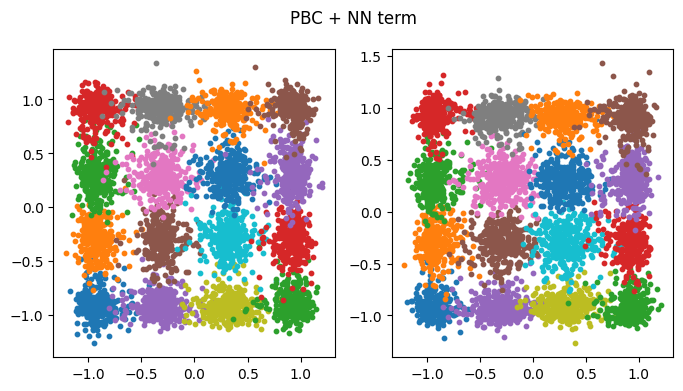

In [32]:
show_symb(y_nn.data.numpy() + y_pbc.data.numpy() - y1.data[:,20,:].numpy(), x1.numpy(), title='PBC + NN term')

In [33]:
error = y_nn.data.numpy()  + y_pbc.data.numpy() - y1.data[:,20,:].numpy() - x1.numpy()

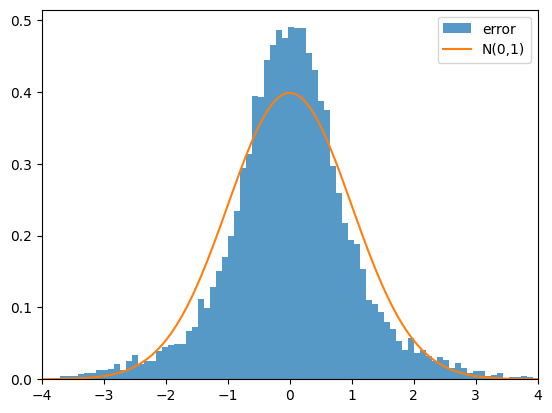

In [34]:
# plot distribution of normalized error.real
import matplotlib.pyplot as plt
datas = error.real.flatten()
datas = (datas - np.mean(datas)) / np.std(datas)
_ = plt.hist(datas, bins=100, density=True, alpha=0.75, label='error')
plt.xlim(-4, 4)

# plot pdf of N(0,1)
import scipy.stats as stats
x = np.linspace(-4, 4, 100)
plt.plot(x, stats.norm.pdf(x, 0, 1), label='N(0,1)')

plt.legend()

Text(0.5, 1.0, 'BER well function')

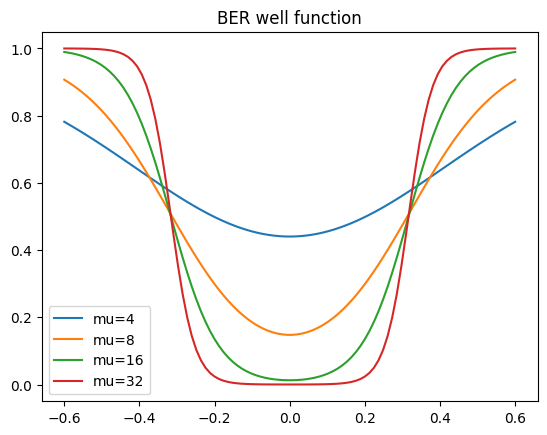

In [35]:
import torch, matplotlib.pyplot as plt

def well(x, mu=1):
    return torch.sigmoid(mu*(x - 0.3162)) + torch.sigmoid(mu*(-x - 0.3162))

x = torch.linspace(-0.6, 0.6, 100)

y = well(x, mu=4)
plt.plot(x, y, label='mu=4')

y = well(x, mu=8)
plt.plot(x, y, label='mu=8')

y = well(x, mu=16)
plt.plot(x, y, label='mu=16')

y = well(x, mu=32)
plt.plot(x, y, label='mu=32')

plt.legend()

plt.title('BER well function')

In [36]:
for key in dic.keys():
    print(key)

model
train epoch
metric
train_path
test_path
Rs
Nch
Pch
idx_train
idx_test
Memory
batch_size
model_name
model info
seed
epochs
save_interval
loss_type
adapt_mu
opt
opt info
scheduler
scheduler info
device
model_path
tensorboard_path
